# Udacity Self-Driving Nanodegree
## Advanced Lane Lines

### Lane Detection Pipeline
1. Camera Calibration
2. Distortion Correction
3. Color Gradient Threshold
4. Perspective Transform

### Dependencies

In [8]:
import glob
import os
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### Camera Calibration

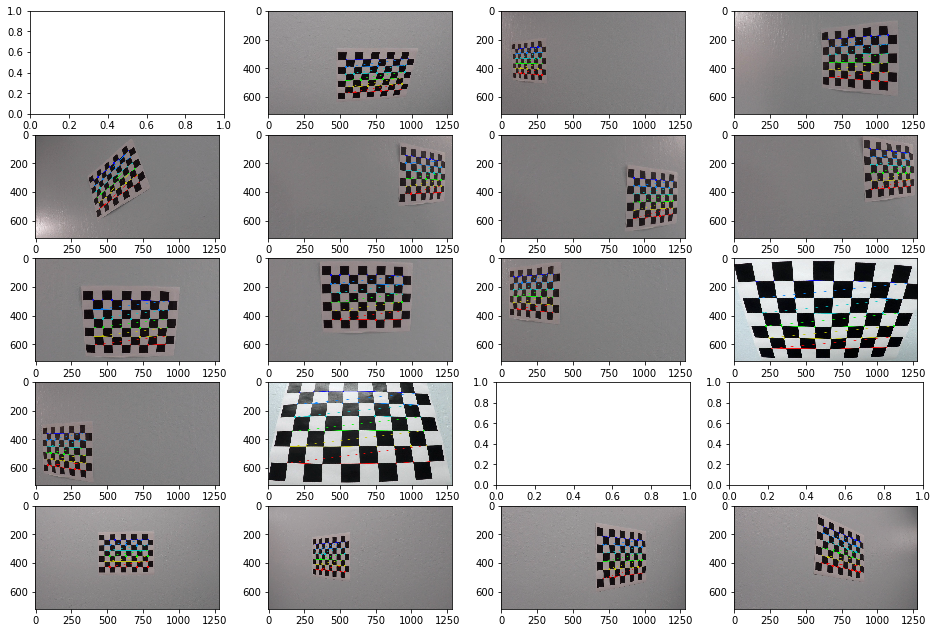

In [13]:
objgrid = np.zeros((9*6, 3), np.float32)
objgrid[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

objpts = [] # 3D points in real-world space
imgpts = [] # 2D points in image plane

images = glob.glob('camera_cal/calibration*.jpg')

grid, axes = plt.subplots(5, 4, figsize=(16, 11))
axes = axes.ravel()

for idx, filename in enumerate(images):    
    img = cv2.imread(filename)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

    if ret == True:       
        objpts.append(objgrid)
        imgpts.append(corners)
        
        detected = cv2.drawChessboardCorners(img, (9, 6), corners, ret)
        # a blank panel means that corners were unable to be detected
        axes[idx].imshow(detected)

### Undistortion


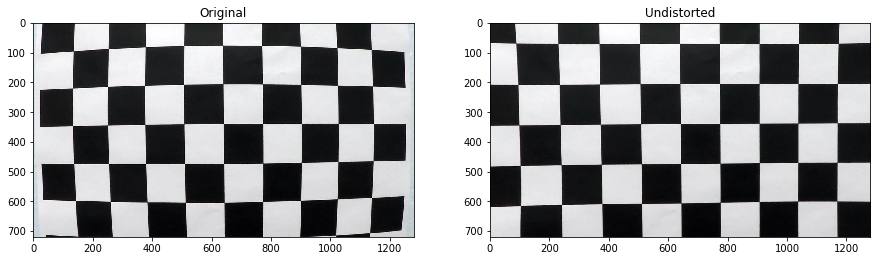

In [22]:
test_img = cv2.imread('camera_cal/calibration1.jpg')

img_size = (test_img.shape[1], test_img.shape[0])

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpts, imgpts, img_size, None, None)
undist = cv2.undistort(test_img, mtx, dist, None, mtx)

dist_pickle = {}
dist_pickle['mtx'] = mtx
dist_pickle['dist'] = dist
pickle.dump(dist_pickle, open('dist_pickle.p', 'wb'))

grid, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 7))
axis1.set_title('Original')
axis1.imshow(test_img)
axis2.set_title('Undistorted')
axis2.imshow(undist)

### Image Thresholding

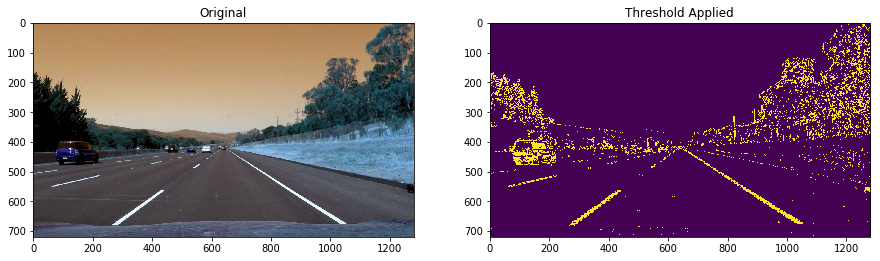

In [33]:
def apply_threshold(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)

    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:, :, 1]
    s_channel = hls[:, :, 2]

    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)

    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint(255 * abs_sobelx / np.max(abs_sobelx))

    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    combined = np.zeros_like(sxbinary)
    combined[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined

test_img = cv2.imread('test_images/straight_lines2.jpg')

grid, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 7))
axis1.set_title('Original')
axis1.imshow(test_img)
axis2.set_title('Threshold Applied')
axis2.imshow(apply_threshold(test_img))

### Perspective Transform

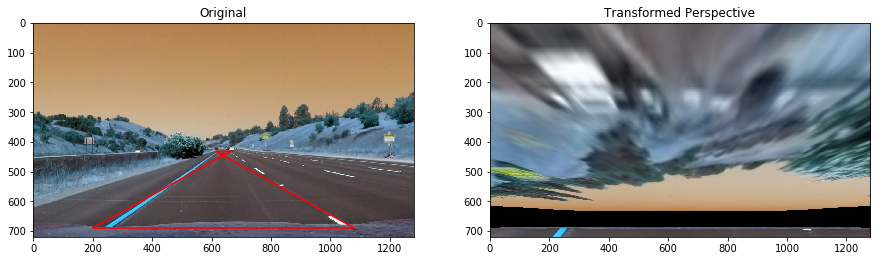

In [54]:
def top_perspective(img):

    height, width = img.shape[0], img.shape[1]
    side_offset = 200
    top_offset = int(height * 0.6) # halve the image to take out images above the horizon
    bottom_offset = 30 # remove the hood of the car
    left, right = int(0.48 * width), int(0.52 * width)

    src = [[left, top_offset], 
           [right, top_offset],
           [width - side_offset, height - bottom_offset],
           [side_offset, height - bottom_offset]]
    
    dst = [[side_offset, 0], 
           [width - side_offset, 0], 
           [width - side_offset, height - bottom_offset],
           [side_offset, height - bottom_offset]]
    
    M = cv2.getPerspectiveTransform(np.float32(src), np.float32(dst))
    warped = cv2.warpPerspective(img, M, img_size)
    return warped, src

test_img = cv2.imread('test_images/straight_lines1.jpg')
transformed, src = top_perspective(test_img)

grid, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 7))
src.append(src[0])
x, y = zip(*src)

axis1.plot(x, y, color='#ff0000')
axis1.set_title('Original')
axis1.imshow(test_img)
axis2.set_title('Transformed Perspective')
axis2.imshow(transformed)